In [ ]:
# switch to main dir to fix local imports
import os
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

# package imports
import networkx as nx
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import torch

# local imports
from src.args import Args
import src.graph_visualization as vis
import src.subgraphs as subgraphs
import src.graphs as graphs
from src.toroid import on_toroid

# start autoreload
%load_ext autoreload
%autoreload 2

# select device for machine learning
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using device: {device}")

# settings for plots (seaborn/matplotlib)
sns.set_context("paper")
sns.set_style("darkgrid", {"grid.color": ".8"})
palette = "Dark2"

### Load dataframe

In [ ]:
result = pd.concat((pd.read_csv(f) for f in glob.glob("/out/load/*.csv.zip")), ignore_index=True)

# Plot RGG

In [ ]:
args = Args(
    graph_type="t_rgg",
    graph_size=500,
    # rgg specific settings
    rgg_avg_degree=10
)
graph = graphs.gen_graph(args)

fig_size = 4
fig, axs = plt.subplots(
    figsize=(fig_size, fig_size)
)

vis.draw_graph(
    ax=axs,
    graph=graph,
    toroid=True
)

plt.tight_layout(pad=0)
plt.savefig('./out/rgg.pdf')

# Plot BFS/DFS subgraph for RGG

In [ ]:
args = Args(
    graph_type="rgg",
    graph_size=500,
    # rgg specific settings
    rgg_avg_degree=10
)
graph = graphs.gen_graph(args)

bfs_sub = subgraphs.bfs_of(graph, args.subgraph_size)
dfs_sub = subgraphs.dfs_of(graph, args.subgraph_size)

fig_size = 4
fig, axs = plt.subplots(
    ncols=2,
    figsize=(fig_size * 2, fig_size)
)

axs[0].set_title(f"BFS", fontsize=12)
vis.draw_graph(
    ax=axs[0],
    graph=graph,
    subgraph=bfs_sub
)

axs[1].set_title(f"DFS", fontsize=12)
vis.draw_graph(
    ax=axs[1],
    graph=graph,
    subgraph=dfs_sub
)

plt.tight_layout(pad=2)
plt.savefig('./out/rgg_bfs_dfs.pdf')

# Plot WRS subgraph for RGG

In [ ]:
args = Args(
    graph_type="rgg",
    graph_size=500,
    # rgg specific settings
    rgg_avg_degree=10
)
graph = graphs.gen_graph(args)

wrs_sub_50 = subgraphs.wrs_of(graph, 50)
wrs_sub_100 = subgraphs.wrs_of(graph, 100)
wrs_sub_200 = subgraphs.wrs_of(graph, 200)

fig_size = 4
fig, axs = plt.subplots(
    ncols=3,
    figsize=(fig_size * 3, fig_size)
)

axs[0].set_title(f"subgraph size = 50")
vis.draw_graph(
    ax=axs[0],
    graph=graph,
    subgraph=wrs_sub_50
)
axs[1].set_title(f"subgraph size = 100")
vis.draw_graph(
    ax=axs[1],
    graph=graph,
    subgraph=wrs_sub_100
)
axs[2].set_title(f"subgraph size = 200")
vis.draw_graph(
    ax=axs[2],
    graph=graph,
    subgraph=wrs_sub_200
)

plt.tight_layout(pad=2)
plt.savefig('./out/rgg_wrs.pdf')

# Plot RJS subgraph for RGG and GIRG

In [ ]:
rgg_args = Args(
    graph_type="rgg",
    graph_size=500,
    # rgg specific settings
    rgg_avg_degree=10
)
rgg_graph = graphs.gen_graph(rgg_args)

rgg_rjs_sub_00 = subgraphs.rjs_of(rgg_graph, rgg_args.subgraph_size, alpha=0.0)
rgg_rjs_sub_05 = subgraphs.rjs_of(rgg_graph, rgg_args.subgraph_size, alpha=0.15)
rgg_rjs_sub_10 = subgraphs.rjs_of(rgg_graph, rgg_args.subgraph_size, alpha=1.0)

girg_args = Args(
    graph_type="girg",
    graph_size=500,
)
girg_graph = graphs.gen_graph(girg_args)

girg_rjs_sub_00 = subgraphs.rjs_of(girg_graph, girg_args.subgraph_size, alpha=0.0)
girg_rjs_sub_05 = subgraphs.rjs_of(girg_graph, girg_args.subgraph_size, alpha=0.15)
girg_rjs_sub_10 = subgraphs.rjs_of(girg_graph, girg_args.subgraph_size, alpha=1.0)

fig_size = 30
fig, axs = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(fig_size / 2, fig_size / 3)
)

axs[0][0].set_title(f"alpha = 0.0")
vis.draw_graph(
    ax=axs[0][0],
    graph=rgg_graph,
    subgraph=rgg_rjs_sub_00
)
axs[0][1].set_title(f"alpha = 0.15")
vis.draw_graph(
    ax=axs[0][1],
    graph=rgg_graph,
    subgraph=rgg_rjs_sub_05
)
axs[0][2].set_title(f"alpha = 1.0")
vis.draw_graph(
    ax=axs[0][2],
    graph=rgg_graph,
    subgraph=rgg_rjs_sub_10
)

vis.draw_graph(
    ax=axs[1][0],
    graph=girg_graph,
    subgraph=girg_rjs_sub_00,
    toroid=True
)
vis.draw_graph(
    ax=axs[1][1],
    graph=girg_graph,
    subgraph=girg_rjs_sub_05,
    toroid=True
)
vis.draw_graph(
    ax=axs[1][2],
    graph=girg_graph,
    subgraph=girg_rjs_sub_10,
    toroid=True
)

plt.tight_layout(pad=2)
plt.savefig('./out/rgg_girg_rjs.pdf')
plt.show()

In [ ]:
fig_size = 4
fig, axs = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(fig_size * 3, fig_size * 2)
)

axs[0][0].set_title(f"alpha = 0.0")
vis.draw_graph(
    ax=axs[0][0],
    graph=rgg_graph,
    subgraph=rgg_rjs_sub_00
)
axs[0][1].set_title(f"alpha = 0.15")
vis.draw_graph(
    ax=axs[0][1],
    graph=rgg_graph,
    subgraph=rgg_rjs_sub_05
)
axs[0][2].set_title(f"alpha = 1.0")
vis.draw_graph(
    ax=axs[0][2],
    graph=rgg_graph,
    subgraph=rgg_rjs_sub_10
)

vis.draw_graph(
    ax=axs[1][0],
    graph=girg_graph,
    subgraph=girg_rjs_sub_00,
    toroid=True
)
vis.draw_graph(
    ax=axs[1][1],
    graph=girg_graph,
    subgraph=girg_rjs_sub_05,
    toroid=True
)
vis.draw_graph(
    ax=axs[1][2],
    graph=girg_graph,
    subgraph=girg_rjs_sub_10,
    toroid=True
)

plt.tight_layout(pad=2)
plt.savefig('./out/rgg_girg_rjs.pdf')
plt.show()

# Plot GIRG

In [ ]:
args = Args(
    graph_type="girg",
    graph_size=100,
)
graph = graphs.gen_graph(args)

fig_size = 10
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

vis.draw_graph(
    ax=ax,
    graph=graph,
    toroid=True
)
plt.tight_layout(pad=0)
plt.savefig('./out/girg.pdf')
plt.show()

# Plot RJS subgraph for GIRG

In [ ]:
args = Args(
    graph_type="girg",
    graph_size=500,
)
graph = graphs.gen_graph(args)

rjs_sub_00 = subgraphs.rjs_of(graph, args.subgraph_size, alpha=0.0)
rjs_sub_05 = subgraphs.rjs_of(graph, args.subgraph_size, alpha=0.15)
rjs_sub_10 = subgraphs.rjs_of(graph, args.subgraph_size, alpha=1.0)

fig_size = 15
fig, axs = plt.subplots(
    ncols=3,
    figsize=(fig_size, fig_size / 3)
)

axs[0].set_title(f"alpha = 0.0")
vis.draw_graph(
    ax=axs[0],
    graph=graph,
    subgraph=rjs_sub_00,
    toroid=True
)
axs[1].set_title(f"alpha = 0.15")
vis.draw_graph(
    ax=axs[1],
    graph=graph,
    subgraph=rjs_sub_05,
    toroid=True
)
axs[2].set_title(f"alpha = 1.0")
vis.draw_graph(
    ax=axs[2],
    graph=graph,
    subgraph=rjs_sub_10,
    toroid=True
)

plt.tight_layout(pad=2)
plt.savefig('./out/girg_rjs.pdf')
plt.show()

# Visualize graph on torus

In [ ]:
args = Args(
    graph_type="girg",
    graph_size=10,
    girg_deg=8
)

graph = graphs.gen_graph(args)

In [ ]:
cmap = sns.color_palette("Spectral", as_cmap=True)
fig = plt.figure(figsize=(20, 10))

n = 100
theta = np.linspace(0, 2.*np.pi, n)
phi = np.linspace(0, 2.*np.pi, n)
theta, phi = np.meshgrid(theta, phi)
c, a = 2, 1
x = (c + a*np.cos(theta)) * np.cos(phi)
y = (c + a*np.cos(theta)) * np.sin(phi)
z = a * np.sin(theta)

ax1 = fig.add_subplot(121, projection='3d')
ax1.set_zlim(-3,3)
ax1.plot_surface(x, y, z, rstride=5, cstride=5, edgecolors=cmap(0.9))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.grid(False)
plt.axis('off')


display_graph = on_toroid(graph)
node_colors = [
    cmap(0.0) if any(["shift" in d and d["shift"] != "none" for (_, _, d) in display_graph.edges(u, data=True)]) else cmap(1.0)
    for u in list(display_graph.nodes)
]
edge_colors = [
    cmap(0.1) if s != "none" else cmap(0.9)
    for (u, v, s) in display_graph.edges(data="shift")
]

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.set_xlim(left=0, right=1)
ax2.set_ylim(bottom=0, top=1)
nx.draw_networkx(
    display_graph,
    pos=display_graph.nodes.data("pos"),
    node_color=node_colors,
    edge_color=edge_colors,
    with_labels=False,
    node_size=1.5,
    ax=ax2
)

plt.tight_layout(pad=2)
plt.show()
fig.savefig("./out/torus.pdf")

# Visualize Embedding

In [15]:
graph = graphs.gen_rgg(30, avg_degree=8)

/home/paul/Projects/embedding-eval-framework/venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


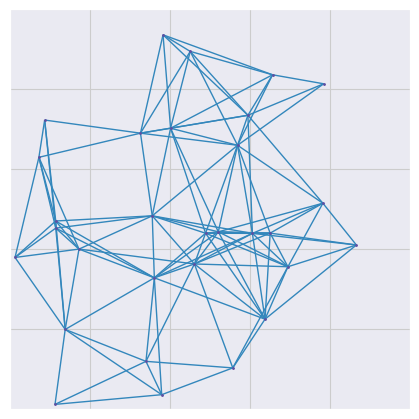

In [26]:
# the graph
fig_size = 4
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

vis.draw_graph(
    ax=ax,
    graph=graph
)

plt.tight_layout(pad=0)
plt.savefig("./out/ge_graph.pdf")

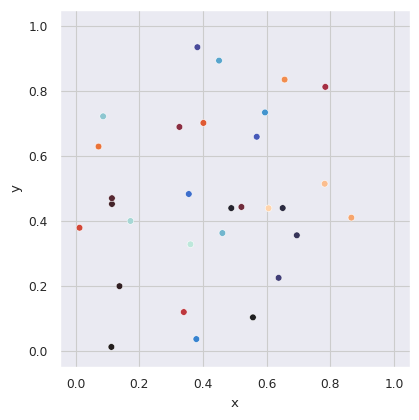

In [33]:
# the perfect embedding
fig_size = 4
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

features = list(graph.nodes(data="feature"))
data = pd.DataFrame({
    "x": [x for (_, (x, _)) in features],
    "y": [y for (_, (_, y)) in features],
    "hue": range(len(features))
})
g = sns.scatterplot(
    data=data,
    x="x",
    y="y",
    hue="hue",
    ax=ax,
    palette="icefire",
    legend=False
)
g.set(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05))

plt.tight_layout(pad=0)
plt.savefig("./out/ge_embedding.pdf")

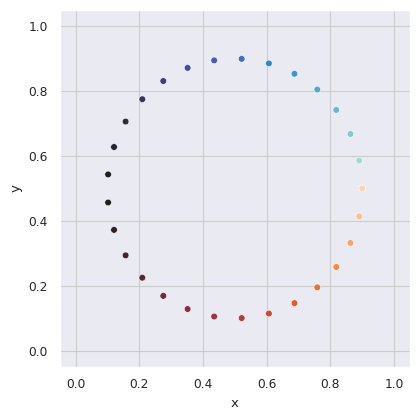

In [34]:
# a random embedding (here on a circle)
fig_size = 4
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

theta = np.linspace(0, 2*np.pi, 30)
data = pd.DataFrame({
    "x": 0.4 * np.cos(theta) + 0.5,
    "y": 0.4 * np.sin(theta) + 0.5,
    "hue": range(30)
})
g = sns.scatterplot(
    data=data,
    x="x",
    y="y",
    hue="hue",
    ax=ax,
    palette="icefire",
    legend=False
)
g.set(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05))

plt.tight_layout(pad=0)
plt.savefig("./out/ge_embedding_random.pdf")

# Visualize RGG radius

In [128]:
size = 300
avg_degree = 10
graph = graphs.gen_rgg(size, avg_degree=avg_degree)

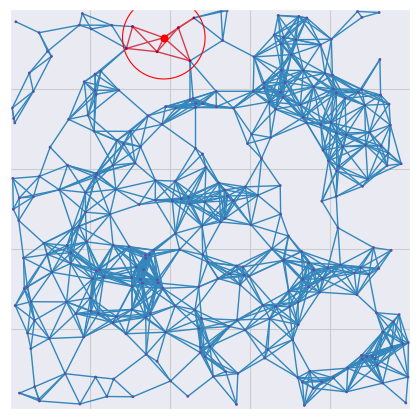

In [129]:
fig_size = 4
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

node_i = 0
radius = np.sqrt(avg_degree / ((size - 1) * np.pi))
sub = nx.subgraph(graph, [node_i, *list(graph.neighbors(node_i))])
vis.draw_graph(
    ax=ax,
    graph=graph,
    subgraph=sub
)

pos = graph.nodes(data="feature")[node_i]
circle = plt.Circle(pos, radius, color="r", fill=False)
ax.add_patch(circle)
ax.plot((pos[0]), (pos[1]), 'o', color='r')

plt.tight_layout(pad=0)
plt.savefig("./out/rgg_radius.pdf")

# Visualize random graph

In [145]:
size = 30
avg_degree = 5
graph = graphs.gen_rgg(size, avg_degree=avg_degree)
graph = graphs.randomized_graph(graph)
nx.set_node_attributes(graph, {i: f for (i, f) in list(graph.nodes(data="feature"))}, name="pos")

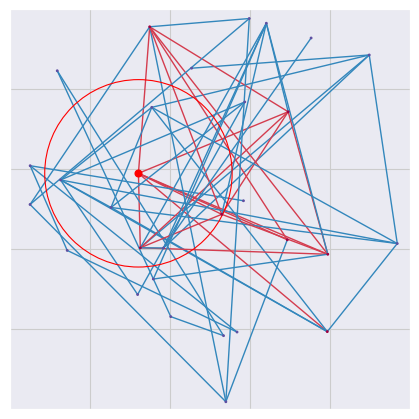

In [146]:
fig_size = 4
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

node_i = 0
radius = np.sqrt(avg_degree / ((size - 1) * np.pi))
sub = nx.subgraph(graph, [node_i, *list(graph.neighbors(node_i))])
vis.draw_graph(
    ax=ax,
    graph=graph,
    subgraph=sub
)

pos = graph.nodes(data="feature")[node_i]
circle = plt.Circle(pos, radius, color="r", fill=False)
ax.add_patch(circle)
ax.plot((pos[0]), (pos[1]), 'o', color='r')

plt.tight_layout(pad=0)
plt.savefig("./out/rgg_small_random_radius.pdf")

# Visualize general subsampling

In [156]:
size = 300
avg_degree = 10
graph = graphs.gen_rgg(size, avg_degree=avg_degree)
sub = subgraphs.rjs_of(graph, 50)

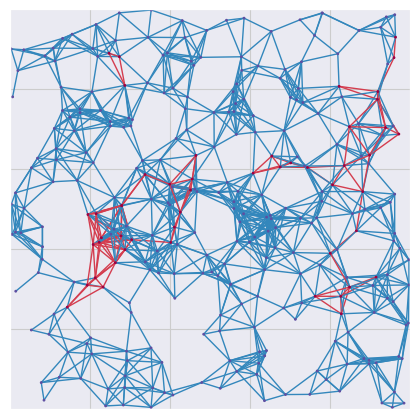

In [160]:
fig_size = 4
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

vis.draw_graph(
    ax=ax,
    graph=graph,
    subgraph=sub
)

plt.tight_layout(pad=0)
plt.savefig("./out/rgg_sub_1.pdf")

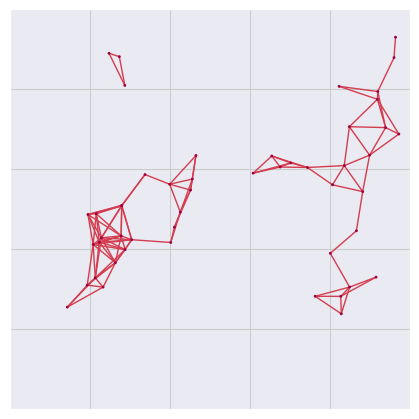

In [161]:
fig_size = 4
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

vis.draw_graph(
    ax=ax,
    graph=sub,
    subgraph=sub
)

plt.tight_layout(pad=0)
plt.savefig("./out/rgg_sub_2.pdf")